In [0]:
#import all the necessary packages
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.utils import np_utils
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import RMSprop, adam
from keras import backend as K
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

import sklearn
from sklearn.tree import export_graphviz
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler

from IPython.display import SVG

import csv
import os 
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import scipy as sp
import PIL
import seaborn as sea
import warnings
warnings.filterwarnings("ignore")

Specify the path name and mention the sampling rate

In [0]:
#give the path name of the directory
Directory = 'LunarLanderFramesPart1/'
#sample the data for faster processing
sample_rate  = 0.8
#Set number of rows
Row = 84;
#set number of columns
Column = 84;
#set Channel
Channels = 1;

Created the filemane from the folder mentioned in the directory variable and applied random sampling to the input data


In [0]:
# generate filenames from the data folder and do sampling
filenames = [Directory+i for i in os.listdir(Directory) if not i.startswith('.')] 
#performing random sampling without replacement
filenames = random.sample(filenames, int(len(filenames)*sample_rate))
# store the data into array
count = len(filenames)
print("The total number of training data is:",count)
data = np.ndarray((count, Channels, Row, Column), dtype=np.float) 

The total number of training data is: 50936


iterate through each of the image to perform the following:
1. convert the image to grayscale image
2. shrinke the image
3. normalize the given data

In [0]:
#Iterate through the filenames to shrink the image and convert the image to gray scale. 
for i, image_name in enumerate(filenames):
    #converting the image into grayscale 
    image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE) 
    #Shrinking the image size
    image = cv2.resize(image, (Row, Column), interpolation=cv2.INTER_CUBIC)
    data[i] = image  
    #normalising the data 
    data[i] = data[i]/255 
    if i%1500 == 0: 
        print("Processed" , i ,"records from" , count )  

Processed 0 records from 50936
Processed 1500 records from 50936
Processed 3000 records from 50936
Processed 4500 records from 50936
Processed 6000 records from 50936
Processed 7500 records from 50936
Processed 9000 records from 50936
Processed 10500 records from 50936
Processed 12000 records from 50936
Processed 13500 records from 50936
Processed 15000 records from 50936
Processed 16500 records from 50936
Processed 18000 records from 50936
Processed 19500 records from 50936
Processed 21000 records from 50936
Processed 22500 records from 50936
Processed 24000 records from 50936
Processed 25500 records from 50936
Processed 27000 records from 50936
Processed 28500 records from 50936
Processed 30000 records from 50936
Processed 31500 records from 50936
Processed 33000 records from 50936
Processed 34500 records from 50936
Processed 36000 records from 50936
Processed 37500 records from 50936
Processed 39000 records from 50936
Processed 40500 records from 50936
Processed 42000 records from 5

create the labels from the files name file, to create the label we will consider the 6th letter from the last of the filename (handeled to ignore .jpeg) and convert the labels to binary encoded labels

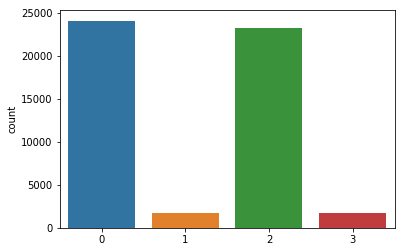

In [0]:
# Extract the lables based on the last character of the filename
labels = []
for i in filenames:
    l = i[-6:-5] 
    #performing type casting
    labels.append(int(l))  
    
# getting the total number of unique classes
total_classes = len(set(labels)) 

#convert to binary encoded labels
labels_wide = keras.utils.to_categorical(labels, total_classes) 

# To understand the distribution, plot the bar chart
sea.countplot(labels) 

2


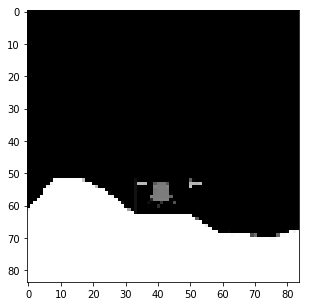

2


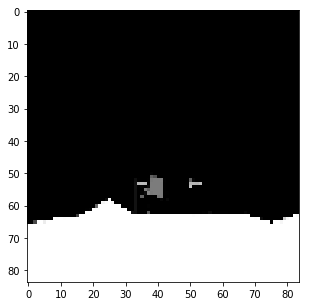

In [0]:
for i in range(0,2):
  #Returns random integers
    img = random.randint(0, len(labels)) 
    print(labels[img]) 
    plt.figure(figsize=(5,5))  
    plt.imshow(data[img][0], cmap='gray') 
    plt.show()

Use relu and softmax as the activation function

In [0]:
# create model
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(Channels, Row, Column), data_format='channels_first'))  
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3))) 

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Activation('relu'))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2))) 

model.add(Flatten()) 
model.add(Dense(128))
model.add(Activation('relu'))
                                       
model.add(Dropout(0.5))

model.add(Dense(total_classes)) 
model.add(Activation('softmax'))

#Compile the model before use
model.compile(loss='categorical_crossentropy', 
              optimizer=adam(lr=1e-3), 
              metrics=['accuracy']) 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 32, 84, 84)        320       
_________________________________________________________________
activation_37 (Activation)   (None, 32, 84, 84)        0         
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 10, 28, 84)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 10, 28, 64)        48448     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 3, 9, 64)          0         
_________________________________________________________________
activation_38 (Activation)   (None, 3, 9, 64)          0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 3, 9, 128)         73856     
__________

In [0]:
seed = 42
np.random.seed(42)
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=seed)
cross_validation_scores = []
epochs=50

Fold Number 1
Class distribution for fold: 1


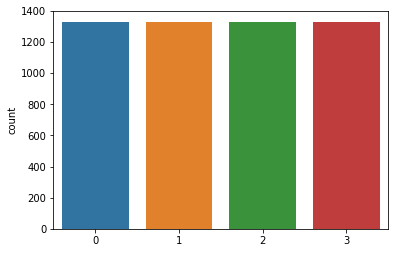

Train on 3993 samples, validate on 1331 samples
Epoch 1/50
3993/3993 [==============================] - 30s 7ms/step - loss: 1.3850 - acc: 0.2795 - val_loss: 1.3350 - val_acc: 0.4282
Epoch 2/50
3993/3993 [==============================] - 32s 8ms/step - loss: 1.2530 - acc: 0.4225 - val_loss: 1.1486 - val_acc: 0.5004
Epoch 3/50
3993/3993 [==============================] - 31s 8ms/step - loss: 1.1245 - acc: 0.5049 - val_loss: 1.0515 - val_acc: 0.5657
Epoch 4/50
3993/3993 [==============================] - 30s 7ms/step - loss: 1.0332 - acc: 0.5482 - val_loss: 0.9893 - val_acc: 0.5853
Epoch 5/50
3993/3993 [==============================] - 27s 7ms/step - loss: 0.9747 - acc: 0.5770 - val_loss: 0.9640 - val_acc: 0.5838
Epoch 6/50
3993/3993 [==============================] - 29s 7ms/step - loss: 0.9376 - acc: 0.5860 - val_loss: 0.9532 - val_acc: 0.5838
Epoch 7/50
3993/3993 [==============================] - 28s 7ms/step - loss: 0.9081 - acc: 0.6011 - val_loss: 0.9540 - val_acc: 0.5823
Epoch 8

predicted,0,1,2,3,All
True,,,,,
0,3508,759,1053,708,6028
1,60,295,86,5,446
2,834,1326,2367,1291,5818
3,63,14,124,243,444
All,4465,2394,3630,2247,12736




 
Test Loss Fold 1 ): 2.256357018222761
Test Accuracy (Fold 1 ):50.35%
acc: 50.35%


 Model Accuracy (Fold 1 ):


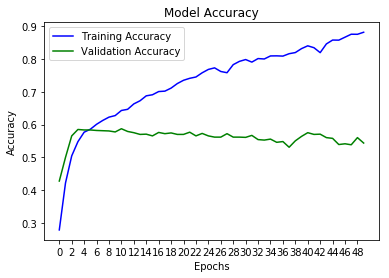

Fold Number 2
Class distribution for fold: 2


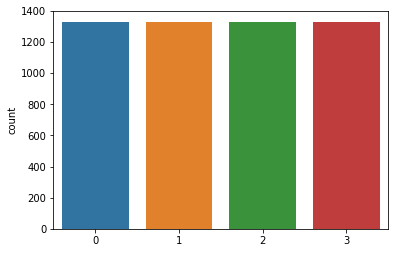

Train on 3993 samples, validate on 1331 samples
Epoch 1/50
3993/3993 [==============================] - 31s 8ms/step - loss: 1.0560 - acc: 0.5788 - val_loss: 0.8819 - val_acc: 0.6213
Epoch 2/50
3993/3993 [==============================] - 31s 8ms/step - loss: 0.8445 - acc: 0.6223 - val_loss: 0.8532 - val_acc: 0.6206
Epoch 3/50
3993/3993 [==============================] - 34s 8ms/step - loss: 0.7841 - acc: 0.6484 - val_loss: 0.8537 - val_acc: 0.6334
Epoch 4/50
3993/3993 [==============================] - 33s 8ms/step - loss: 0.7347 - acc: 0.6564 - val_loss: 0.8651 - val_acc: 0.6334
Epoch 5/50
3993/3993 [==============================] - 31s 8ms/step - loss: 0.6952 - acc: 0.6829 - val_loss: 0.8787 - val_acc: 0.6258
Epoch 6/50
3993/3993 [==============================] - 31s 8ms/step - loss: 0.6711 - acc: 0.6895 - val_loss: 0.9085 - val_acc: 0.6341
Epoch 7/50
3993/3993 [==============================] - 31s 8ms/step - loss: 0.6268 - acc: 0.7112 - val_loss: 0.9396 - val_acc: 0.6228
Epoch 8

predicted,0,1,2,3,All
True,,,,,
0,3262,1119,1090,557,6028
1,24,325,94,2,445
2,716,1452,2897,752,5817
3,46,28,160,210,444
All,4048,2924,4241,1521,12734




 
Test Loss Fold 2 ): 2.613667015941734
Test Accuracy (Fold 2 ):52.57%
acc: 52.57%


 Model Accuracy (Fold 2 ):


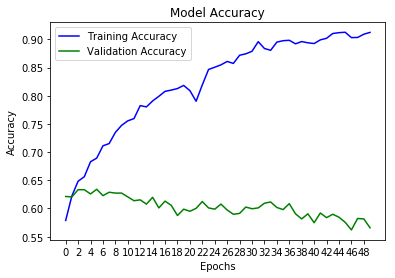

Fold Number 3
Class distribution for fold: 3


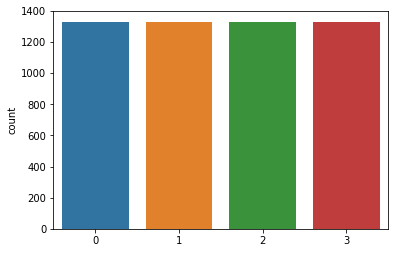

Train on 3993 samples, validate on 1331 samples
Epoch 1/50
3993/3993 [==============================] - 30s 7ms/step - loss: 1.1625 - acc: 0.5404 - val_loss: 0.9021 - val_acc: 0.5913
Epoch 2/50
3993/3993 [==============================] - 31s 8ms/step - loss: 0.8435 - acc: 0.6339 - val_loss: 0.8536 - val_acc: 0.6409
Epoch 3/50
3993/3993 [==============================] - 31s 8ms/step - loss: 0.7614 - acc: 0.6509 - val_loss: 0.8593 - val_acc: 0.6386
Epoch 4/50
3993/3993 [==============================] - 30s 8ms/step - loss: 0.7076 - acc: 0.6757 - val_loss: 0.8679 - val_acc: 0.6491
Epoch 5/50
3993/3993 [==============================] - 30s 8ms/step - loss: 0.6592 - acc: 0.6900 - val_loss: 0.8853 - val_acc: 0.6341
Epoch 6/50
3993/3993 [==============================] - 30s 7ms/step - loss: 0.6353 - acc: 0.7057 - val_loss: 0.9260 - val_acc: 0.6424
Epoch 7/50
3993/3993 [==============================] - 30s 8ms/step - loss: 0.5975 - acc: 0.7203 - val_loss: 0.9866 - val_acc: 0.6266
Epoch 8

predicted,0,1,2,3,All
True,,,,,
0,3258,481,1412,877,6028
1,43,288,107,7,445
2,659,645,3329,1184,5817
3,28,1,134,281,444
All,3988,1415,4982,2349,12734




 
Test Loss Fold 3 ): 2.646559426562461
Test Accuracy (Fold 3 ):56.20%
acc: 56.20%


 Model Accuracy (Fold 3 ):


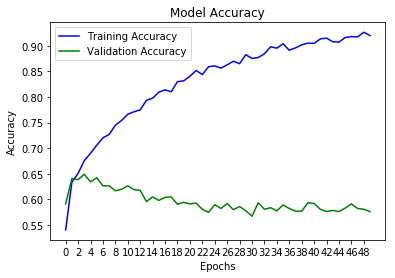

Fold Number 4
Class distribution for fold: 4


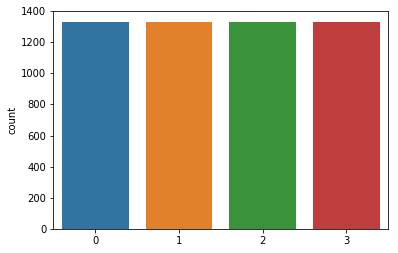

Train on 3996 samples, validate on 1332 samples
Epoch 1/50
3996/3996 [==============================] - 33s 8ms/step - loss: 1.1683 - acc: 0.6046 - val_loss: 0.9123 - val_acc: 0.5931
Epoch 2/50
3996/3996 [==============================] - 32s 8ms/step - loss: 0.8484 - acc: 0.6414 - val_loss: 0.9012 - val_acc: 0.6156
Epoch 3/50
3996/3996 [==============================] - 32s 8ms/step - loss: 0.7352 - acc: 0.6814 - val_loss: 0.8866 - val_acc: 0.6141
Epoch 4/50
3996/3996 [==============================] - 31s 8ms/step - loss: 0.6761 - acc: 0.7047 - val_loss: 0.9145 - val_acc: 0.6471
Epoch 5/50
3996/3996 [==============================] - 32s 8ms/step - loss: 0.6270 - acc: 0.7170 - val_loss: 0.9245 - val_acc: 0.6396
Epoch 6/50
3996/3996 [==============================] - 31s 8ms/step - loss: 0.5765 - acc: 0.7377 - val_loss: 1.0234 - val_acc: 0.6254
Epoch 7/50
3996/3996 [==============================] - 32s 8ms/step - loss: 0.5452 - acc: 0.7530 - val_loss: 1.0730 - val_acc: 0.6254
Epoch 8

predicted,0,1,2,3,All
True,,,,,
0,3715,668,854,790,6027
1,43,336,64,2,445
2,1076,1138,2186,1417,5817
3,47,3,65,328,443
All,4881,2145,3169,2537,12732




 
Test Loss Fold 4 ): 2.983668153929403
Test Accuracy (Fold 4 ):51.56%
acc: 51.56%


 Model Accuracy (Fold 4 ):


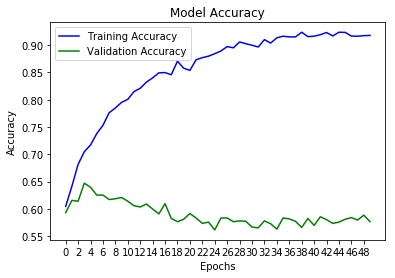



 Model accuracy (over all folds): 52.67% (+/- 2.18%)


In [0]:
fold=0
for train, test in kfold.split(data, labels):
    fold = fold + 1
    labels_train=[]
    for i in range(len(train)):
        labels_train.append(labels[train[i]])
    # Convert to binary encoded labels
    labels_train_enc = keras.utils.to_categorical(labels_train, total_classes) 
    
    labels_test=[]
    for i in range(len(test)):
        labels_test.append(labels[test[i]])
    # Convert to binary encoded labels
    labels_test_enc = keras.utils.to_categorical(labels_test, total_classes) 
    #Apply random-sampling to adjust the class distribution
    random_sampler = RandomUnderSampler(return_indices=True)
    train_rs, train_labels_rs, resampled = random_sampler.fit_sample(data[train].reshape(len(data[train]), Row*Column*Channels), labels_train)

    train_rs, train_labels_rs = shuffle(train_rs, train_labels_rs)
    train_rs = train_rs.reshape(len(train_rs), Channels,Row, Column) 
    
    print('=======================================================================================================')

    #Plot the graph for the distributed data
    print("Fold Number", fold)
    print('Class distribution for fold:', fold)
    ax = sea.countplot(train_labels_rs)
    sea.countplot(train_labels_rs)
    plt.show()

    # convert to binary encoded labels
    train_labels_rs_wide = keras.utils.to_categorical(train_labels_rs, total_classes)
    
    # Train the model
    history = model.fit(train_rs, train_labels_rs_wide, 
                    batch_size=128, 
                    epochs=epochs, 
                    validation_split=0.25, 
                    verbose=1, shuffle=False)
    
    # Make a set of predictions for the validation data
    print("Test data")
    pred = model.predict_classes(data[test])
    
    # Print performance details
    print(metrics.classification_report(labels_test, pred))
    
    # Print confusion matrix
    print('Confusion Matrix :', fold)
    display(pd.crosstab(np.array(labels_test),pred,rownames=['True'],colnames=['predicted'],margins ='True'))

    
    # Score some test data; Score trained model.
    scores = model.evaluate(data[test], labels_test_enc, verbose=0)
    print('\n\n \nTest Loss Fold',fold,'):', scores[0])
    print('Test Accuracy (Fold',fold,'):%.2f%%' % (scores[1]*100))
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cross_validation_scores.append(scores[1] * 100)
    
    # Summarize history for accuracy and Plot it
    print('\n\n Model Accuracy (Fold',fold,'):')
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc, 'blue', label='Training Accuracy')
    plt.plot(val_acc, 'green', label='Validation Accuracy')
    plt.xticks(range(0,epochs)[0::2])
    plt.legend()
    plt.show()
    
print("\n\n Model accuracy (over all folds): %.2f%% (+/- %.2f%%)" % (np.mean(cross_validation_scores), np.std(cross_validation_scores)))

In [0]:
filepath = "Supervised.mod"
model.save(filepath)